# Assignment 1
## Problem 6 - Normalizing Flows

Normalizing flows are generative models that allow efficient sampling and density estimation. They can be used for image generation, which is in this problem for a very simple binary image. In our example, bivariate distributions are used to allow easy visualization.

--------------------------
In this task, the normalizing flows do not have to be implemented from scratch. **Pyro** and **Pytorch** are used to construct the normalizing flows. In a first step, all necessary libraries and modules are imported. 



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import matplotlib.pyplot as plt
import numpy as np
import pyro.distributions as dist
import torch
from matplotlib import cm
from src.utils.io import load_image, img_to_bw

import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T

from src.utils.plotting import init_plot_style, show_grayscale_img
#%pylab

init_plot_style()
data_dir='../../data/img/'

&ensp;
<hr style='border:2.2px solid Black'></hr>

#### Data preparation

If necessary, we first have to convert our grayscale icons to a binary image.

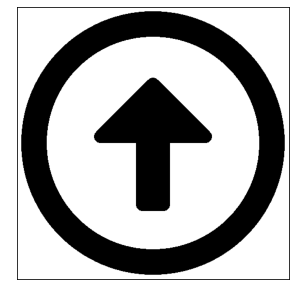

In [2]:
img = img_to_bw(data_dir + 'up.png', data_dir + 'up_bw.png')
show_grayscale_img(img,figsize=(5, 5))

Now we can load the binary image and generate samples from it as described in the assignment sheet.

Our image format is 512 x 512.


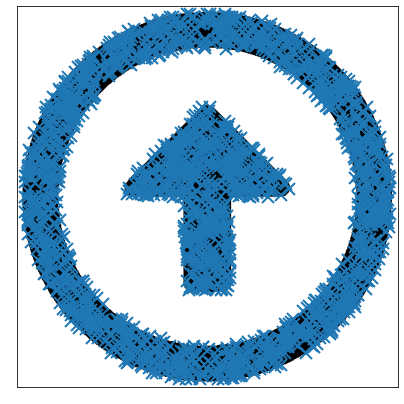

In [3]:
# load image
img = load_image(data_dir + 'up_bw.png')
height, width = img.shape
print(f'Our image format is {width} x {height}.')

# generate training samples
n_samples = 2000 # number of samples to generate
data = np.zeros((n_samples, 2))
rng = np.random.default_rng(seed=0)
i=0
while i < n_samples:
    row = rng.integers(0, height)
    col = rng.integers(0, width)
    if img[row, col] == 0:
        data[i,0] = col
        data[i,1] = row
        i += 1

# plot image with generated samples
show_grayscale_img(img,figsize=(7, 7))
plt.plot( data[:,0], data[:,1], 'x')
plt.xlim([0, width])
_ = plt.ylim([0, height])


&ensp;
<hr style='border:2.2px solid Black'></hr>

### Pre-processing

Our image format is 512x512 px. But in order to further process the samples of the image efficiently using normalizing flows, the samples are normalized to [-1,1]. 

The normalizing flow is implemented using Pyro (see this [Tutorial](https://pyro.ai/examples/normalizing_flows_i.html)). For the coupling transform [`SplineCoupling`](https://docs.pyro.ai/en/stable/distributions.html#pyro.distributions.transforms.SplineCoupling) is used. The input parameter *bound=K* determines the bounding box ([−K,K]×[−K,K]) of the spline - the default value is K=3. 

The training process of the normalizing flow works efficiently when the input is normalized to [-1,1].

In [4]:
data_normalized = (data/512-0.5)*2
print(f'Our pre-processed samples lie in the range [{np.min(data_normalized)} , {np.max(data_normalized)}].')

Our pre-processed samples lie in the range [-0.9609375 , 0.9609375].


<div style="page-break-after: always;"></div>
<p style="page-break-after:always;"></p>

<hr style='border:1.5px solid Black'></hr>
<hr style='border:0.5px solid Gray'></hr>

### Task a) Implement a coupling flow (spline coupling flow)

<hr style='border:0.5px solid Gray'></hr>
<hr style='border:1.5px solid Black'></hr>


First, the base distribution is specified. In our case it is chosen as a random variable $X$ with the distribution of a simple multivariate Gaussian with zero mean and unit covariance matrix: 

$$ \mathbf{X} \sim \mathcal{N}(\mu = \mathbf{0}_{2x1}, \Sigma = I_{2x2}) $$

The random variable $\mathbf{X}$ is then transformed by a bijective function: $\mathbf{Y}=\mathbf{g}(\mathbf{X})$.
This base distribution $p_\mathbf{X}(\mathbf{x})$ is transformed with the *change-of-variables* formula as such: 

\begin{align}
     p_\mathbf{Y}(\mathbf{y}) = p_\mathbf{X}\left(\mathbf{g}^{-1}(\mathbf{y})\right)~\left|~\det\left(~\frac{d\mathbf{g}^{-1}(\mathbf{y})}{d\mathbf{x}}~\right)~\right|.
\end{align}

The function $\mathbf{g}(.)$ typically is created by composition of several function $\mathbf{g}(\mathbf{x})=\mathbf{g}_k(\mathbf{g}_{k-1}(\dots (\mathbf{g}_1(\mathbf{x}))))$ - this allows us to gain more expressibility. 

In our case it is formed by a spline coupling layer (see [SplineCoupling](https://docs.pyro.ai/en/stable/distributions.html#splinecoupling)) with the following parameters

* *input_dim* = 2
* *hidden_dim* = [input_dim * 30] * 10
* *count_bins* = 32
* *bound* = 3

which led to appropriate results.

In [5]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
input_dim = 2
hidden_dims = [input_dim * 30]*10
transform_coupling = T.spline_coupling(input_dim=2, hidden_dims=hidden_dims, count_bins=32, bound=3)
flow_dist_coupling = dist.TransformedDistribution(base_dist, [transform_coupling])

<hr style='border:0.5px solid Gray'></hr>

**Training**:
Then the parameters of the spline-coupling layer are learnt in a stochastic gradient descent where the log-likelihood is maximized (ML principle). 

The parameters of the stochastic gradient descent are chosen as such:
* *number of samples* = 2000
* *epochs* = 2000
* *learning_rate* = 2e-2

In [6]:
%%time

steps = 2_000

dataset = torch.tensor(data_normalized, dtype=torch.float)
optimizer = torch.optim.Adam(transform_coupling.parameters(), lr=2e-2)

for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist_coupling.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist_coupling.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))
        
print('Achieved log-likelihood: ', -loss.item())

step: 0, loss: 4.658216953277588
step: 500, loss: 0.4221729636192322
step: 1000, loss: 0.40775859355926514
step: 1500, loss: 0.37266847491264343
step: 2000, loss: 0.37579163908958435
Achieved log-likelihood:  -0.37579163908958435
Wall time: 1min 16s


<hr style='border:0.5px solid Gray'></hr>

Now that the function $\mathbf{g}(.)$ is learnt, we can sample from the trained flow distribution. In total 5000 samples are generated and shown in a scatter plot with the original b/w picture.
We can observe, that the quality of the sampling process is acceptable. Most samples lie in the correct region with some small deviation.

Wall time: 72.6 ms


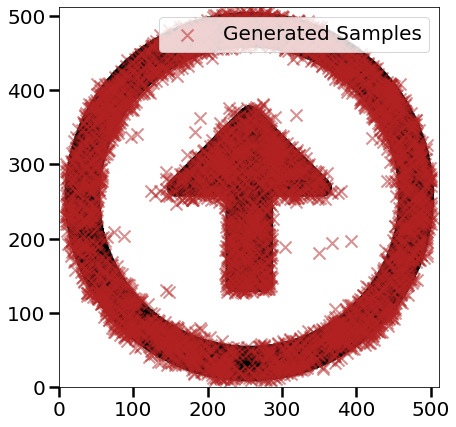

In [7]:
%%time

# generate samples from the learned distribution
samples_coupling = flow_dist_coupling.sample(torch.Size([5000,])).detach().numpy()
samples_coupling = (samples_coupling/2+0.5)*512

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap='gray', vmin=0, vmax=255, origin='lower')
ax.scatter(samples_coupling[:,0], samples_coupling[:,1], color='firebrick', 
           label='Generated Samples', alpha=0.5,  marker='x')
ax.set_xlim([0,512])
ax.set_ylim([0,512])
_ = ax.legend(loc="upper right")

<hr style='border:0.5px solid Gray'></hr>

We also want to have a look at the log-likelihood of our model!

Wall time: 1.16 s


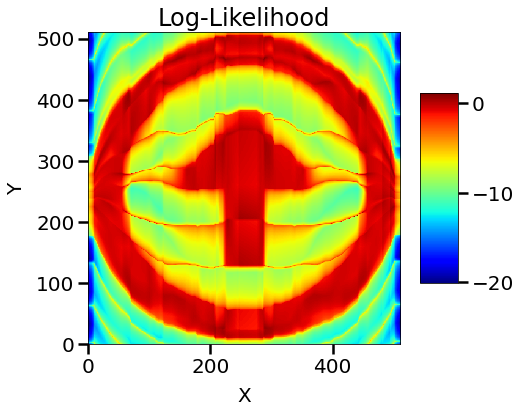

In [8]:
%%time

# compute the log-likelihood at a discrete grid
rows = np.arange(0, width)
cols = np.arange(0, height)

X, Y = np.meshgrid(cols, rows)

# flatten the grid points and evaluate their log-liklihoods
coordinates = torch.FloatTensor(np.stack((X,Y), axis=2)).view(-1, 2)
log_likelihood_coupling = flow_dist_coupling.log_prob((coordinates/512*2-1)).detach().view(-1,width).numpy()

# finally, let's plot the log-likelihood
fig, ax = plt.subplots(figsize=(7, 7))
levels = np.linspace(-18, 3, 20)
c = plt.imshow(log_likelihood_coupling, cmap = 'jet', 
            vmin = np.min(log_likelihood_coupling), vmax = np.max(log_likelihood_coupling),
            extent =[X.min(), X.max(), Y.min(), Y.max()],
            interpolation ='nearest', origin ='lower')

plt.colorbar(c, shrink=0.5, aspect=5)
  
ax.set_xlabel('X')
ax.set_ylabel('Y')
_ = ax.set_title('Log-Likelihood')

<div style="page-break-after: always;"></div>
<p style="page-break-after:always;"></p>

<hr style='border:1.5px solid Black'></hr>
<hr style='border:0.5px solid Gray'></hr>

### Task b) Implement an autoregressive flow (spline autoregressive flow)

<hr style='border:0.5px solid Gray'></hr>
<hr style='border:1.5px solid Black'></hr>



Again, the base distribution is specified as a multivariate Gaussian with zero mean and unit covariance matrix: 

$$ \mathbf{X} \sim \mathcal{N}(\mu = \mathbf{0}_{2x1}, \Sigma = I_{2x2}) $$

The transformation of the random variable $\mathbf{X}$ with distribution $p_\mathbf{X}(\mathbf{x})$ by a function $\mathbf{g}(.)$ is performed by an autoregressive flow. The [autoregressive layer](https://docs.pyro.ai/en/stable/distributions.html#splineautoregressive) in our solution is implemented with spline functions. In task c) the *coupling* and *autoregressive* flow are explained in more detail and compared to each other.  

For the autoregressive spline layer the following parameters are specified:

* *input_dim* = 2
* *hidden_dim* = [input_dim x 30 &ensp; input_dim x 30]
* *count_bins* = 32
* *bound* = 3

which led to appropriate results.

In [9]:
from pyro.nn import AutoRegressiveNN

input_dim = 2
count_bins = 32
base_dist = dist.Normal(torch.zeros(input_dim), torch.ones(input_dim))
hidden_dims = [input_dim * 30]*10
param_dims = [count_bins, count_bins, count_bins - 1, count_bins]
hypernet = AutoRegressiveNN(input_dim, hidden_dims, param_dims=param_dims)
transform_auto = T.SplineAutoregressive(input_dim, hypernet, count_bins=count_bins, bound=3)
flow_dist_auto = dist.TransformedDistribution(base_dist, [transform_auto])

<hr style='border:0.5px solid Gray'></hr>

**Training**:
Again, the parameters of the splines are learnt in a stochastic gradient descent where the log-likelihood is maximized (ML principle). 

The parameters of the stochastic gradient descent are chosen the same as in task a):

* *number of samples* = 2000
* *epochs* = 2000
* *learning_rate* = 2e-2

In [10]:
%%time

steps = 2_000

dataset = torch.tensor(data_normalized, dtype=torch.float)
optimizer = torch.optim.Adam(transform_auto.parameters(), lr=2e-2)

for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist_auto.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist_auto.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))
        
print('Achieved log-likelihood: ', -loss.item())

step: 0, loss: 2.1732373237609863
step: 500, loss: 0.43861255049705505
step: 1000, loss: 0.43714672327041626
step: 1500, loss: 0.4343864321708679
step: 2000, loss: 0.49865832924842834
Achieved log-likelihood:  -0.49865832924842834
Wall time: 2min 47s


<hr style='border:0.5px solid Gray'></hr>

Then 5000 samples are generated from the trained flow distribution and shown in a scatter plot with the original b/w picture.
Also for the autoregressive flow the generated samples are quite reasonable given the simple implementation of the normalizing flow with a quite short execution time. The are some outliers, but the location of most samples does not deviate too much.

Wall time: 69.4 ms


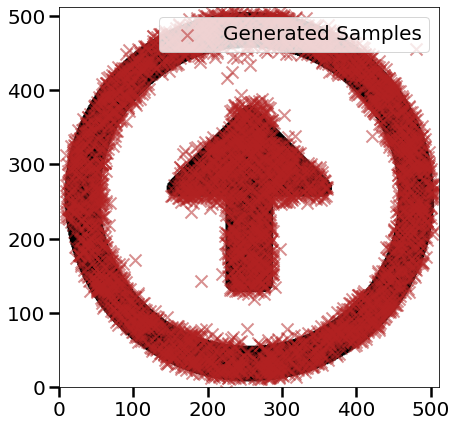

In [11]:
%%time

# generate samples from the learned distribution
samples_auto = flow_dist_auto.sample(torch.Size([5000,])).detach().numpy()
samples_auto = (samples_auto/2+0.5)*512

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap='gray', vmin=0, vmax=255, origin='lower')
ax.scatter(samples_auto[:,0], samples_auto[:,1], color='firebrick', label='Generated Samples', alpha=0.5,  marker='x')
ax.set_xlim([0,512])
ax.set_ylim([0,512])
_ = ax.legend(loc="upper right")

<hr style='border:0.5px solid Gray'></hr>

We also want to have a look at the log-likelihood of our model!

Wall time: 6.88 s


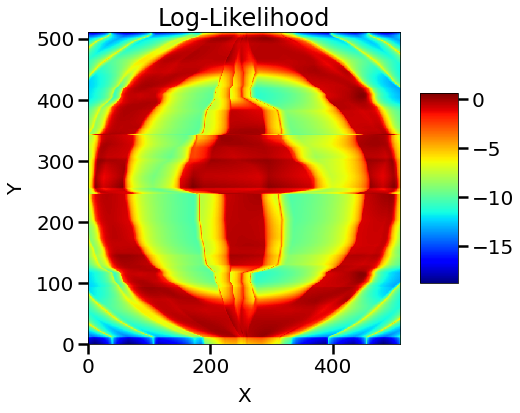

In [12]:
%%time

# compute the log-likelihood at a discrete grid
rows = np.arange(0, width)
cols = np.arange(0, height)

X, Y = np.meshgrid(cols, rows)

# flatten the grid points and evaluate their log-liklihoods
coordinates = torch.FloatTensor(np.stack((X,Y), axis=2)).view(-1, 2)
log_likelihood_auto = flow_dist_auto.log_prob((coordinates/512*2-1)).detach().view(-1,width).numpy()

# finally, let's plot the log-likelihood
fig, ax = plt.subplots(figsize=(7, 7))
levels = np.linspace(-18, 3, 20)
c = plt.imshow(log_likelihood_auto, cmap = 'jet', vmin = np.min(log_likelihood_auto), vmax = np.max(log_likelihood_auto),
            extent =[X.min(), X.max(), Y.min(), Y.max()],
            interpolation ='nearest', origin ='lower')
plt.colorbar(c, shrink=0.5, aspect=5)
  
ax.set_xlabel('X')
ax.set_ylabel('Y')
_ = ax.set_title('Log-Likelihood')

<div style="page-break-after: always;"></div>
<p style="page-break-after:always;"></p>

<hr style='border:1.5px solid Black'></hr>
<hr style='border:0.5px solid Gray'></hr>

### Task c) Comparison: coupling vs autoregressive flow

<hr style='border:0.5px solid Gray'></hr>
<hr style='border:1.5px solid Black'></hr>


As mentioned earlier, normalizing flows make use of the *change-of-variables* formula in order to approximate a probability distribution given some samples drawn from it. Starting point is a simple base distribution, e.g. a zero-mean, unit variance Gaussian distribution $\mathbf{X} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$ that can be generated easily. This random variable is then transformed by a bijective function $\mathbf{g}(.)$ with an inverse $\mathbf{f}(.)$ that is also differentiable.

\begin{align}
     p_\mathbf{Y}(\mathbf{y}) &= p_\mathbf{X}\left(\mathbf{g}^{-1}(\mathbf{y})\right)~\left|~\det\left(~\frac{d\mathbf{g}^{-1}(\mathbf{y})}{d\mathbf{x}}~\right)~\right|.
\end{align}

The target distribution is then approximated by transforming the base distribution by this function $\mathbf{g}(.)$ (generator). The target distribution $p_\mathbf{X}(\mathbf{x})$ is often also denoted as "*noise*". The function can be determined as an optimization problem by maximizing the log-likelihood e.g. with a stochastic gradient descent. 

In order to generate samples from the approximate distribution $p_\mathbf{Y}(\mathbf{y})$, we simply need to generate samples from the base distribution and transform them with the generator function $\mathbf{y} = \mathbf{g}(\mathbf{x})$. The opposite direction is given by the inverse function $\mathbf{f}(.)$, that transforms the complex distribution back to the base distribution. As the base distribution is often chosen to be a normal distribution, the whole procedure got the name *Normalizing Flows*. [[Kobyzev_2020]](https://arxiv.org/abs/1908.09257).

The function $\mathbf{g}(.)$ can be chosen as a composition of $k$ invertible functions 

$$\mathbf{g}(\mathbf{x})=\mathbf{g}_k(\mathbf{g}_{k-1}(\dots (\mathbf{g}_1(\mathbf{x}))))$$.

Then it can be shown that $\mathbf{g}(.)$ is bijective and its inverse exists: [[Kobyzev_2020]](https://arxiv.org/abs/1908.09257).

$$det\left( \frac{\partial \mathbf{f}}{\partial \mathbf{x}} \right) = \prod\limits_{i=1}^k det\left(\frac{\partial \mathbf{f}_i}{\partial \mathbf{x}} \right)~~.$$


<hr style='border:0.5px solid Gray'></hr>

### Coupling flows:




The vector valued derivative of the inverse function is also known as the Jacobian matrix. The complexity of the computation of the determinant of the Jacobian matrix scales as $\mathcal{O}(n^3)$ with n being the dimension of the data ($\mathbf{x} \in \mathbb{R}^n$). Therefore, we would like to have some efficient implementation of the determinant of the Jacobian.
In coupling flows we make use of the fact that the determinant of a lower (or upper) triangular matrix is the product of the diagonal entries. In addition to that, coupling flows allow the construction of very expressive functions to transform the base distribution.

For a more detailed description of coupling flows see the paper [**Neural Spline Flows**](https://papers.nips.cc/paper/2019/file/7ac71d433f282034e088473244df8c02-Paper.pdf), the following information about coupling flows is taken from there. [[Durkan_2019neural]](https://arxiv.org/abs/1906.04032)


**Overview**:

* The input vector $\mathbf{x}$ is split into two disjoint parts: $[\mathbf{x}_{1:d},~\mathbf{x}_{d+1:D}]$
* The first part of the vector is mapped directly to the output vector, i.e. $\mathbf{y}_{1:d} = \mathbf{x}_{1:d}$
* Using the first part of the vector, we compute parameters $\Theta=c(\mathbf{x}_{1:d})$, where $c(.)$ can be a deep neural network
* These parameters are used to parameterize a function $\mathbf{g}_\Theta$ that is used to map the second part of the input vector to the output vector $\mathbf{y}_{i} = g_{\Theta_i}(\mathbf{x}_{i})$ for $i = d+1,\dots,D$. This element-wise mapping can be performed in parallel for each $i$.

As the first part of the input vector is mapped one-to-one directly to the first part of the output vector, the Jacobian of the function $g(.)$ is an upper diagonal matrix of the form

$$\frac{\partial \mathbf{g}}{\partial \mathbf{x}} = \begin{pmatrix}
 \mathbf{I} & \mathbf{0} \\
 \frac{\partial c}{\partial \mathbf{x}} & \frac{\partial g_{\Theta}}{\partial \mathbf{x}} \\
\end{pmatrix}$$

and the computation of the determinant simplifies to

$$det\left( \frac{\partial \mathbf{g}}{\partial \mathbf{x}} \right) = \prod\limits_{i=d+1}^D \frac{\partial g_{\Theta_i}(x_i)}{\partial x_i} ~~.$$

*Note that the splitting of the input vector has to be changed for the coupling flow to achieve expressibility, e.g. through permutations.* 

Now the question might arise, how the parameterized function $g_{\Theta_i}$ is chosen. Two popular ways are presented here, both are invertible elementwise transformations:

* **Affine/additive**: An affine transformation is given as $g_{\Theta_i} = \alpha_i x_i + \beta_i$ with the parameter vector $\Theta_i = [\alpha_i,~\beta_i]$ (special case: additive transformation for $\alpha_i = 1$). It can be easily understood, that this transform is simple to invert but might fail in modelling complex distributions, e.g. multimodal distributions. Therefore we want a function that is both quite simple to invert, to differentiate and is expressive in order to model complex distributions.

* **Spline transforms**: Monotonic piecewise polynomials can be used to overcome the above problem of lack of expressibility. Polynomial splines are functions that are defined piecewise by polynomials and are often preferred due to their simplicity and ability to approximate complex shapes. Then the input domain split into $K$ bins and $g_{\Theta_i}$ is defined as a polynomial segment, again parameterized by $\Theta_i$. The polynomial segments have to be continuous and smooth at the bin boundaries. In our implementation using *pyro* and [**SplineCoupling**](https://docs.pyro.ai/en/stable/distributions.html#splinecoupling) according to the documentation linear and quadratic spline segments are used. 



In **summary**, coupling flows have several advantages:
+ efficient computation of the determinant of the Jacobian
+ the inverse can be computed easily in a single pass by repeating the same steps in the opposite direction with $g^{-1}_{\Theta_i}$ (conditioning the parameter vector $\Theta$ stays the same as the first part of the input vector is directly mapped to the output, thus $c(\mathbf{x}_{1:d}) = c(\mathbf{y}_{1:d}) = \Theta$ )
+ no sequential computation
+ the conditioning function $c(.)$ can be arbitrarily complex  (e.g. DNN) as it does not have to be considered in the calculation of the determinant due to the structure of the Jacobian matrix

The coupling transform can be viewed as a *special case of the autoregressive transform* with 2 splits instead of $D$ splits of the input vector. [[Durkan_2019neural, p3]](https://arxiv.org/abs/1906.04032)

<hr style='border:0.5px solid Gray'></hr>

### Autoregressive flows: 
All following information about autoregressive flows is taken from [[Kobyzev_2020]](https://arxiv.org/abs/1908.09257).




**Overview**: 

Autoregressive models can be interpreted as normalizing flows. An autoregressive model is a function $\mathbf{g}: \mathbb{R}^n \rightarrow \mathbb{R}^n$ mapping the input vector $\mathbf{x} \in \mathbb{R}^D$ to the output vector $\mathbf{y} \in \mathbb{R}^D$., where the output $y_i$ depends on the actual and previous entries of the input vector $x_{1:i} = [x_1 \dots x_i]$, for $i = 2,\dots, n$. 

Let the conditioning function $c_i(.)$ be an arbitrary complex function, e.g. a DNN. The parameter vector is a function of previous entries of the input vector: $\Theta_i = c(x_{1:i-1})$. The first parameter is a constant value: $\Theta_0 = constant$.

Then, each entry of the output vector $\mathbf{y}$ is computed by a bijective function $h_{\Theta_i}(.)$ parameterized by the corresponding parameter vector entry: $y_i = h_{\Theta_i}(x_i)$.

Again, it can be shown that the Jacobian of the function $\mathbf{g}(.)$ via an autoregressive flow is a triangular matrix. The determinant can be computed efficiently and has the following form: 

$$det\left( \frac{\partial \mathbf{g}}{\partial \mathbf{x}} \right) = \prod\limits_{i=d+1}^D \frac{\partial h_{\Theta_i}(x_i)}{\partial x_i}$$

Given the input vector $\mathbf{x}$, the computation of $\mathbf{z}$ (*forward path*) can be done in parallel. However, the *backward path* has to be computed sequentially due to the following recursion: 

\begin{align}
x_1 &= h^{-1}_{\Theta_1}(x_1),  &\Theta_1 &= c_1(x_0) \\
x_2 &= h^{-1}_{\Theta_2}(x_2),  &\Theta_2 &= c_2(x_0,x_1)\\
&\vdots &&\vdots\\
x_i &= h^{-1}_{\Theta_i}(x_i),  &\Theta_i &= c_i(x_0,\dots,x_{i-1}),~~~~~ i = 2,\dots, D
\end{align}

Therefore, sampling (*forward path*) can be performed in parallel but density estimation (*backward path*) is inherently sequential. 

***Note***: *The whole implementiation can be flipped, which leads to* "inverse autoregressive flows", *where sampling is sequential and density estimation can be done in parallel.*


<hr style='border:0.5px solid Gray'></hr>

### Summary: 
[[Durkan_2019neural]](https://arxiv.org/abs/1906.04032)

* Coupling flows allow the analytic computation of the inverse in one pass, but are in general less expressive than autoregressive flows
* Autoregressive flows are generally very expressive but slow for sampling or density evaluation due to the sequential nature in one direction
Using spline transforms, also coupling flows can be very flexible in modelling complex distributions. Thus, the performance of coupling and autoregressive flows is very similiar.  

In our implementation, there were no noticable differences in the quality of the different flow implementations.
It could be observed for the autoregressive flow that the run time for sampling is a lot smaller than for density estimation.
Overall, the autoregressive flow does have a longer run time while training and during the density estimation in comparison to the coupling flow. It would be interesting to have a look at inverse autoregressive flows and compare the run time. Sadly, for this assignment there was not enough time left looking until the deadline. 